In [2]:
# Import data from a CSV file using pySpark

from pyspark.sql import SparkSession
from pyspark.sql import SQLContext

# Create a SparkSession
spark = SparkSession.builder.appName("CSV Import").getOrCreate()

# Create a SQLContext
sqlContext = SQLContext(spark)

# Load a CSV file
df = sqlContext.read.format('com.databricks.spark.csv').options(header='true', inferschema='true').load('eda_data_train.csv')

/opt/conda/envs/vscode_pyspark/lib/python3.11/site-packages/pyspark/sql/context.py:113: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [3]:
# Show the data
df.show()

+-----------+-----------+---------+--------------+------------+--------------+--------------+--------------------+--------+---------+-------+--------+--------------------------+-----------------------+-----------------------+----------------+-----------------+--------------+--------------+--------------+---------------+------------+----------------+----------------+
|L4_SRC_PORT|L4_DST_PORT|ICMP_TYPE|ICMP_IPV4_TYPE|DNS_QUERY_ID|DNS_QUERY_TYPE|DNS_TTL_ANSWER|FTP_COMMAND_RET_CODE|IN_BYTES|OUT_BYTES|IN_PKTS|OUT_PKTS|FLOW_DURATION_MILLISECONDS|SRC_TO_DST_SECOND_BYTES|DST_TO_SRC_SECOND_BYTES|LONGEST_FLOW_PKT|SHORTEST_FLOW_PKT|MIN_IP_PKT_LEN|MAX_IP_PKT_LEN|TCP_WIN_MAX_IN|TCP_WIN_MAX_OUT|attack_index|dst_subnet_index|src_subnet_index|
+-----------+-----------+---------+--------------+------------+--------------+--------------+--------------------+--------+---------+-------+--------+--------------------------+-----------------------+-----------------------+----------------+-----------------+--

In [5]:
# Graph Heatmap
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
import pyspark.sql.functions as F

# Converte il DataFrame Spark in un DataFrame Pandas per l'analisi esplorativa
df_pd = df.toPandas()

# Analisi esplorativa dei dati utilizzando Pandas e Seaborn
def features_hisogram(dataframe):
    # Istogrammi delle caratteristiche
    dataframe.hist(bins=20, figsize=(12, 10))
    plt.suptitle("Histograms of Features", fontsize=16)
    plt.tight_layout()
    plt.show()

def heatmap(dataframe):
    # Matrice di correlazione
    correlation_matrix = dataframe.corr()
    plt.figure(figsize=(24, 24))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Correlation Matrix', fontsize=20)
    plt.show()

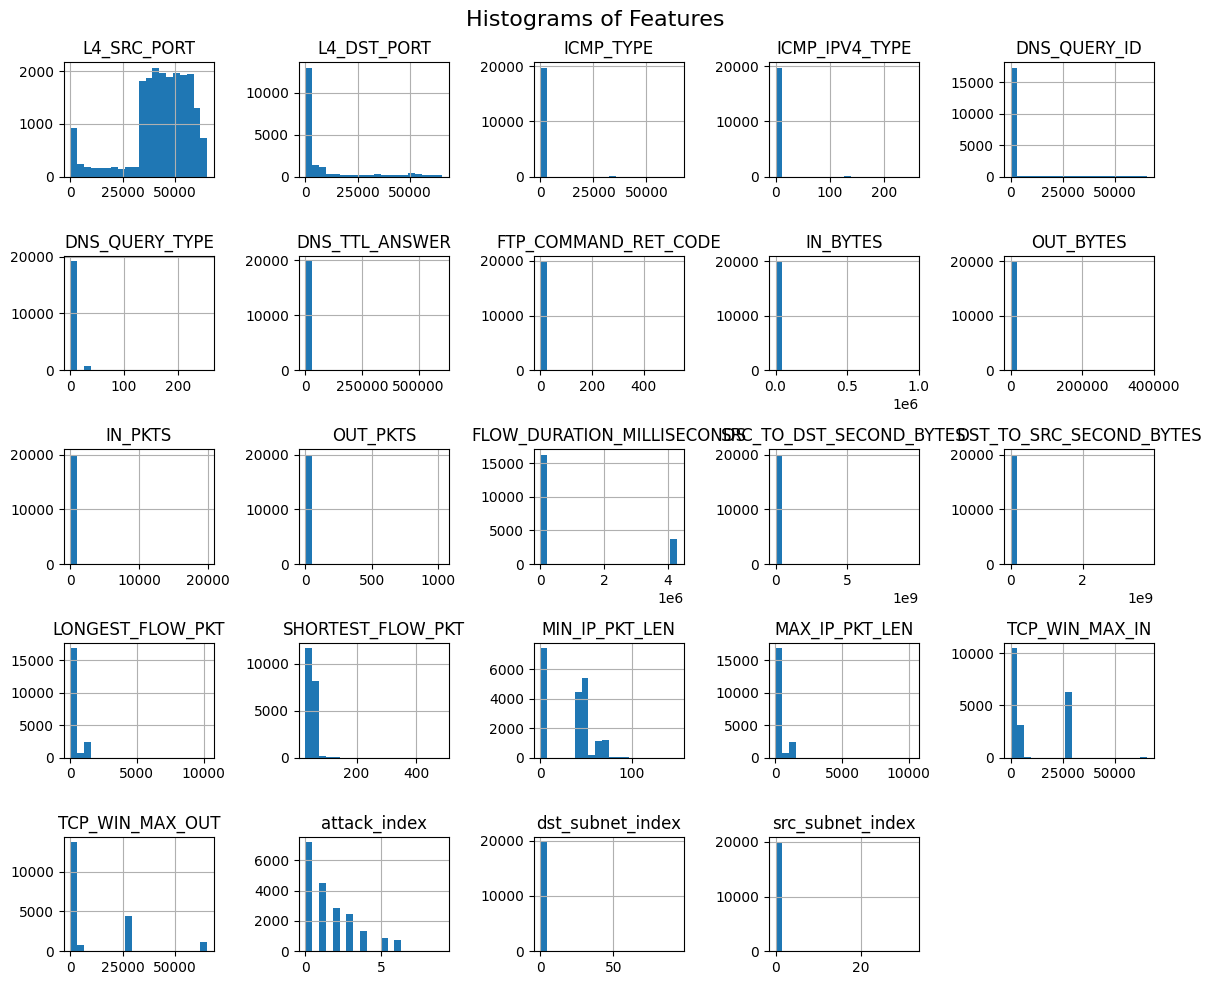

In [6]:
features_hisogram(df_pd)

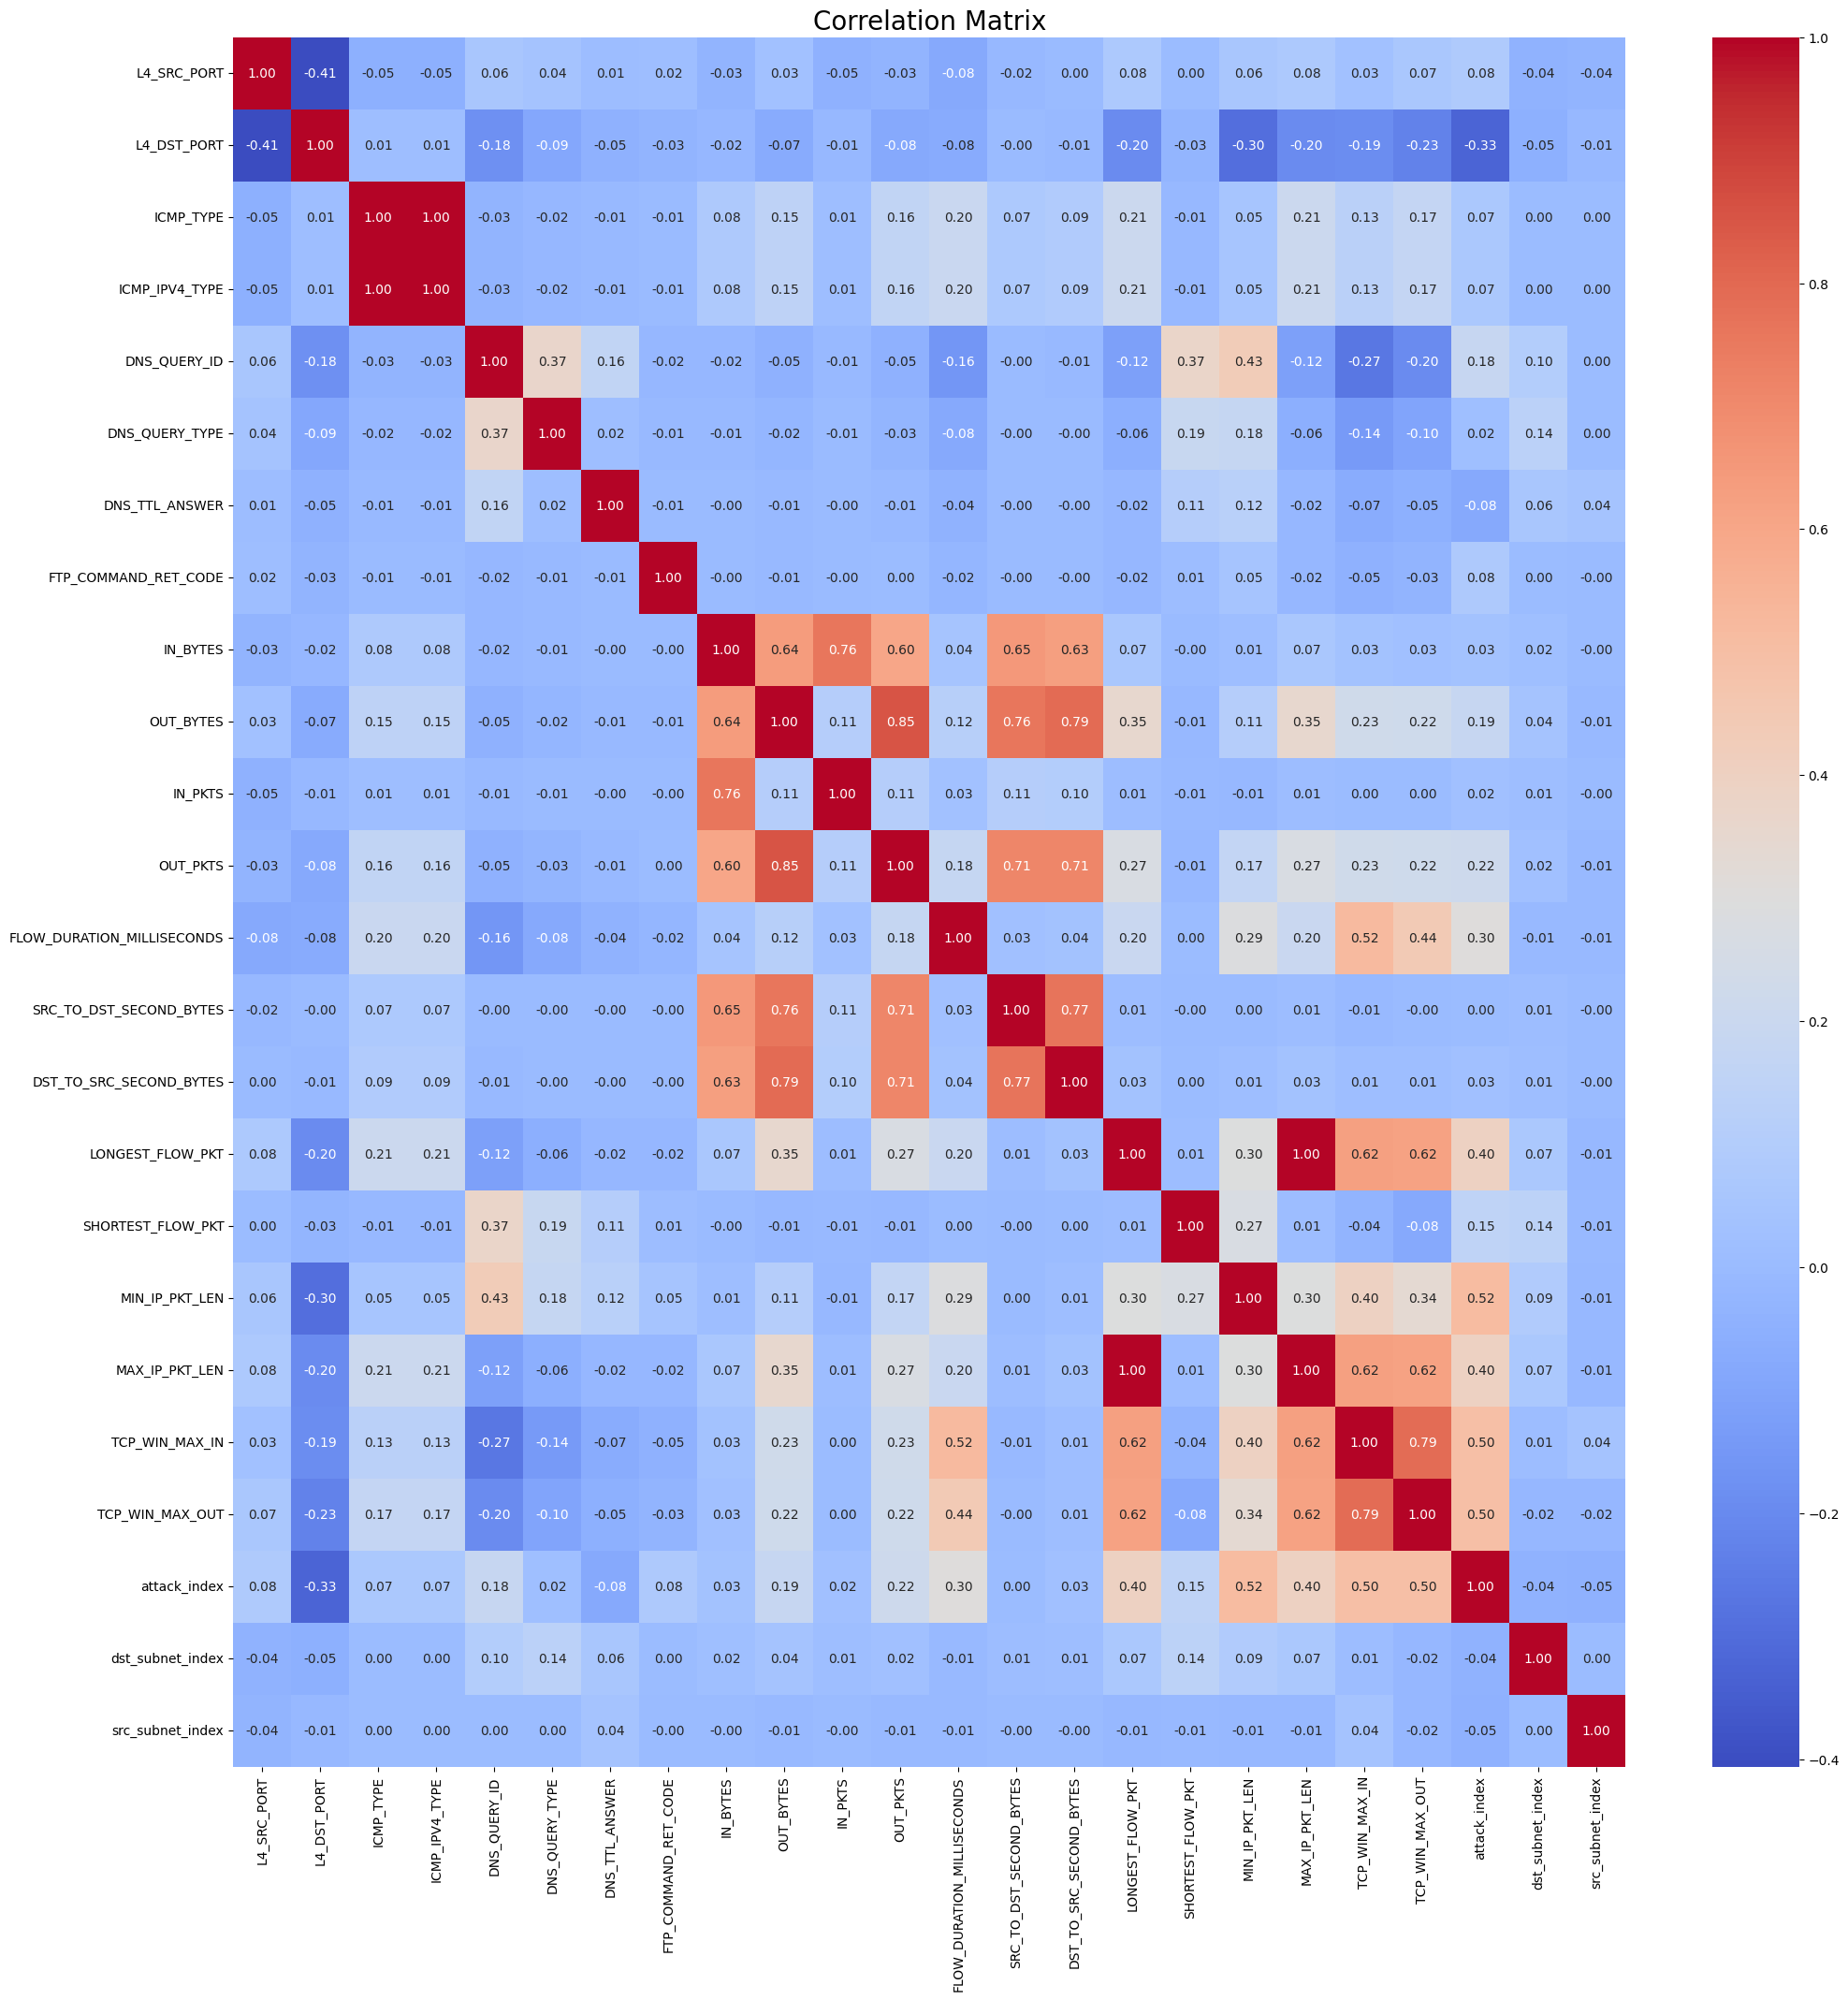

In [7]:
heatmap(df_pd)

In [ ]:
# Frequencias de categoria

from pyspark.sql.functions import count

# Calcular a frequência das categorias na variável 'Attack'
attack_freq = train_data.groupBy("Attack").agg(count("*").alias("frequency")).orderBy("frequency", ascending=False)
attack_freq.show(truncate=False)

# Calcular a frequência das categorias na variável 'IPV4_SRC_ADDR_Subnet'
src_subnet_freq = train_data.groupBy("IPV4_SRC_ADDR_Subnet").agg(count("*").alias("frequency")).orderBy("frequency", ascending=False)
src_subnet_freq.show(truncate=False)

# Calcular a frequência das categorias na variável 'IPV4_DST_ADDR_Subnet'
dst_subnet_freq = train_data.groupBy("IPV4_DST_ADDR_Subnet").agg(count("*").alias("frequency")).orderBy("frequency", ascending=False)
dst_subnet_freq.show(truncate=False)


In [ ]:
# Frequencias de categoria (plot)
import matplotlib.pyplot as plt
import pandas as pd

# Converter para Pandas DataFrame
attack_freq_pd = attack_freq.toPandas()
src_subnet_freq_pd = src_subnet_freq.toPandas()
dst_subnet_freq_pd = dst_subnet_freq.toPandas()

# Visualizar a frequência das categorias na variável 'Attack'
plt.figure(figsize=(10, 6))
plt.bar(attack_freq_pd['Attack'], attack_freq_pd['frequency'], color='blue')
plt.xlabel('Attack')
plt.ylabel('Frequency')
plt.title('Frequency of Attack Categories')
plt.xticks(rotation=90)
plt.show()

# Visualizar as 20 principais categorias na variável 'IPV4_SRC_ADDR_Subnet'
plt.figure(figsize=(10, 6))
plt.bar(src_subnet_freq_pd['IPV4_SRC_ADDR_Subnet'][:20], src_subnet_freq_pd['frequency'][:20], color='green')
plt.xlabel('IPV4_SRC_ADDR_Subnet')
plt.ylabel('Frequency')
plt.title('Top 20 Frequency of Source IP Subnets')
plt.xticks(rotation=90)
plt.show()

# Visualizar as 20 principais categorias na variável 'IPV4_DST_ADDR_Subnet'
plt.figure(figsize=(10, 6))
plt.bar(dst_subnet_freq_pd['IPV4_DST_ADDR_Subnet'][:20], dst_subnet_freq_pd['frequency'][:20], color='red')
plt.xlabel('IPV4_DST_ADDR_Subnet')
plt.ylabel('Frequency')
plt.title('Top 20 Frequency of Destination IP Subnets')
plt.xticks(rotation=90)
plt.show()

In [ ]:
#Outliers Analyses
from scipy.stats import zscore

# Converter para Pandas DataFrame
pd_df = train_data.select("IN_BYTES", "OUT_BYTES", "IN_PKTS", "OUT_PKTS").toPandas()

# Calcular Z-Score
z_scores = zscore(pd_df[["IN_BYTES", "OUT_BYTES", "IN_PKTS", "OUT_PKTS"]])
pd_df["Z_SCORE"] = z_scores

# Visualizar outliers
outliers = pd_df[(pd_df["Z_SCORE"] > 3) | (pd_df["Z_SCORE"] < -3)]
print(outliers)

In [ ]:
#PCA analyses
from pyspark.ml.feature import PCA
from pyspark.ml.linalg import Vectors

# Exemplo de PCA
assembler = VectorAssembler(inputCols=["IN_BYTES", "OUT_BYTES", "IN_PKTS", "OUT_PKTS"], outputCol="features")
pca = PCA(k=2, inputCol="features", outputCol="pca_features")
pipeline = Pipeline(stages=[assembler, pca])
pca_model = pipeline.fit(train_data)
pca_result = pca_model.transform(train_data)

# Visualizar resultado do PCA
pca_result.select("pca_features").show(truncate=False)